# RealNVP on MNIST Fasion

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision
import matplotlib.pyplot as plt
import numpy as np


# Configuration
BATCH_SIZE = 256
LR = 5e-4
EPOCHS = 20
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


## 1. Data loading and preprocessing

Using dequantization - adding noise to convert discrete [0, 255] to continuous space

In [ ]:
class DequantizeAndLogit(object):
    def __init__(self, alpha=0.05):
        self.alpha = alpha

    def __call__(self, x):
        # Dequantize: add uniform noise
        x = x * 255.0 + torch.rand_like(x)
        x = x / 256.0

        # Logit transform to map to R
        x = x * (1 - 2 * self.alpha) + self.alpha
        x = torch.log(x) - torch.log(1 - x)
        return x

    def reverse(self, x):
        x = torch.sigmoid(x)
        x = (x - self.alpha) / (1 - 2 * self.alpha)
        return x

transform = transforms.Compose([
    transforms.ToTensor(),
])


train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

preprocessing = DequantizeAndLogit()


def show_samples(samples, title="Samples"):
    samples = preprocessing.reverse(samples)
    samples = samples.clamp(0, 1)
    grid = torchvision.utils.make_grid(samples.cpu(), nrow=8, padding=2)
    plt.figure(figsize=(10, 10))
    plt.imshow(grid.permute(1, 2, 0))
    plt.title(title)
    plt.axis('off')
    plt.show()

## 2. Model architecture

In [ ]:
class SqueezeLayer(nn.Module):
    def __init__(self, factor=2):
        super().__init__()
        self.factor = factor

    def forward(self, x, reverse=False):
        B, C, H, W = x.shape
        factor = self.factor

        if not reverse:
            if H % factor != 0 or W % factor != 0:
                raise ValueError("Dimensions must be divisible by squeeze factor")

            x = x.view(B, C, H // factor, factor, W // factor, factor)
            x = x.permute(0, 1, 3, 5, 2, 4).contiguous()
            x = x.view(B, C * factor * factor, H // factor, W // factor)
            return x, 0
        else:
            x = x.view(B, C // (factor * factor), factor, factor, H, W)
            x = x.permute(0, 1, 4, 2, 5, 3).contiguous()
            x = x.view(B, C // (factor * factor), H * factor, W * factor)
            return x

class ResBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        # Pre-activation ResBlock with WeightNorm
        self.net = nn.Sequential(
            nn.ReLU(),
            torch.nn.utils.weight_norm(nn.Conv2d(channels, channels, 3, padding=1)),
            nn.ReLU(),
            torch.nn.utils.weight_norm(nn.Conv2d(channels, channels, 3, padding=1))
        )

    def forward(self, x):
        return x + self.net(x)


class CouplingLayer(nn.Module):
    def __init__(self, in_channels, mid_channels):
        super().__init__()
        self.half_channels = in_channels // 2

        # Deep ResNet architecture for capacity
        self.net = nn.Sequential(
            torch.nn.utils.weight_norm(nn.Conv2d(self.half_channels, mid_channels, 3, padding=1)),
            ResBlock(mid_channels),
            ResBlock(mid_channels),
            ResBlock(mid_channels),
            nn.ReLU(),
            torch.nn.utils.weight_norm(nn.Conv2d(mid_channels, self.half_channels * 2, 3, padding=1))
        )

        self.scale = nn.Parameter(torch.zeros(1))

        # Zero init last layer
        self.net[-1].weight.data.zero_()
        self.net[-1].bias.data.zero_()

    def forward(self, x, reverse=False):
        x_a = x[:, :self.half_channels, :, :]
        x_b = x[:, self.half_channels:, :, :]

        st = self.net(x_a)
        s, t = st.chunk(2, dim=1)

        s = self.scale * torch.tanh(s)

        if not reverse:
            y_b = x_b * torch.exp(s) + t
            y = torch.cat([x_a, y_b], dim=1)
            log_det = s.sum(dim=[1, 2, 3])
            return y, log_det
        else:
            x_b = (x_b - t) * torch.exp(-s)
            x = torch.cat([x_a, x_b], dim=1)
            return x


class FlowBlock(nn.Module):
    def __init__(self, channels, num_layers=4, mid_channels=64):
        super().__init__()
        self.layers = nn.ModuleList()
        self.permutations = []

        for i in range(num_layers):
            self.layers.append(CouplingLayer(channels, mid_channels))
            indices = torch.randperm(channels)
            rev_indices = torch.argsort(indices)
            self.permutations.append((indices, rev_indices))

    def forward(self, x, reverse=False):
        log_det_sum = 0
        if not reverse:
            for i, layer in enumerate(self.layers):
                indices, _ = self.permutations[i]
                indices = indices.to(x.device)
                x = x[:, indices]
                x, ld = layer(x, reverse=False)
                log_det_sum += ld
            return x, log_det_sum
        else:
            for i, layer in enumerate(reversed(self.layers)):
                x = layer(x, reverse=True)
                idx = len(self.layers) - 1 - i
                _, rev_indices = self.permutations[idx]
                rev_indices = rev_indices.to(x.device)
                x = x[:, rev_indices]
            return x


In [ ]:
class RealNVP(nn.Module):
    def __init__(self):
        super().__init__()

        # Input: 1 x 28 x 28

        # Scale 1
        self.squeeze1 = SqueezeLayer(2) # -> 4 x 14 x 14
        self.flow1 = FlowBlock(4, num_layers=8, mid_channels=256)

        # Scale 2
        self.squeeze2 = SqueezeLayer(2) # 2 x 14 x 14 -> 8 x 7 x 7
        self.flow2 = FlowBlock(8, num_layers=8, mid_channels=256)

    def forward(self, x, reverse=False):
        if not reverse:
            log_det_sum = 0

            # Scale 1
            x, _ = self.squeeze1(x)
            x, ld = self.flow1(x)
            log_det_sum += ld

            # Split
            z1, x = x.chunk(2, dim=1)

            # Scale 2
            x, _ = self.squeeze2(x)
            x, ld = self.flow2(x)
            log_det_sum += ld

            z2 = x
            return [z1, z2], log_det_sum

        else:
            z1, z2 = x

            # Scale 2 Inverse
            x = self.flow2(z2, reverse=True)
            x = self.squeeze2(x, reverse=True)

            # Merge with z1
            x = torch.cat([z1, x], dim=1)

            # Scale 1 Inverse
            x = self.flow1(x, reverse=True)
            x = self.squeeze1(x, reverse=True)

            return x

    def log_prob(self, x):
        zs, log_det = self(x)
        log_prob = log_det
        for z in zs:
            # Standard Gaussian Prior
            lp = -0.5 * (z ** 2 + np.log(2 * np.pi)).sum(dim=[1, 2, 3])
            log_prob += lp
        return log_prob

## 3. Training Loop

/usr/local/lib/python3.12/dist-packages/torch/nn/utils/weight_norm.py:144: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


Starting training...
Epoch 1/20, Train Loss: 178145.3227, Val Loss: 347.4544, BPD: 0.6394
Epoch 2/20, Train Loss: 178.4614, Val Loss: 62.0310, BPD: 0.1141
Epoch 3/20, Train Loss: -23.0578, Val Loss: -74.5757, BPD: -0.1372
Epoch 4/20, Train Loss: -165.0280, Val Loss: -244.0692, BPD: -0.4491
Epoch 5/20, Train Loss: -324.0492, Val Loss: -366.4392, BPD: -0.6743
Epoch 6/20, Train Loss: -415.7533, Val Loss: -440.6333, BPD: -0.8108
Epoch 7/20, Train Loss: -480.8354, Val Loss: -504.2398, BPD: -0.9279
Epoch 8/20, Train Loss: -536.2089, Val Loss: -541.2510, BPD: -0.9960
Epoch 9/20, Train Loss: -577.3878, Val Loss: -581.8080, BPD: -1.0706
Epoch 10/20, Train Loss: -602.7829, Val Loss: -607.2539, BPD: -1.1175
Epoch 11/20, Train Loss: -635.8364, Val Loss: -626.7799, BPD: -1.1534
Epoch 12/20, Train Loss: -662.4454, Val Loss: -674.8393, BPD: -1.2418
Epoch 13/20, Train Loss: -673.7941, Val Loss: -669.2657, BPD: -1.2316
Epoch 14/20, Train Loss: -692.2435, Val Loss: -706.1247, BPD: -1.2994
Epoch 15/20, T

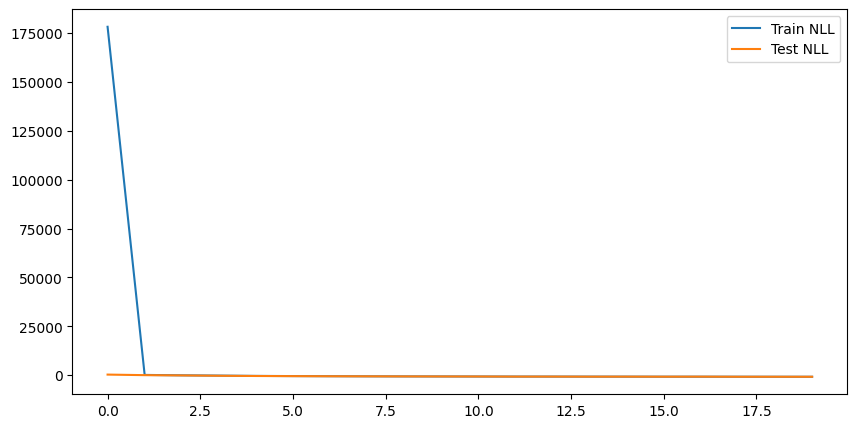

In [5]:
model = RealNVP().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LR)

train_losses = []
test_losses = []

print("Starting training...")

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for x, _ in train_loader:
        x = x.to(DEVICE)
        x = preprocessing(x)

        optimizer.zero_grad()
        loss = -model.log_prob(x).mean()

        if torch.isnan(loss):
            print("NaN loss encountered!")
            break

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x, _ in test_loader:
            x = x.to(DEVICE)
            x = preprocessing(x)
            loss = -model.log_prob(x).mean()
            val_loss += loss.item()

    avg_val_loss = val_loss / len(test_loader)
    test_losses.append(avg_val_loss)

    # Bits per dimension (approximate)
    # NLL / (pixels * log(2))
    bpd = avg_val_loss / (28*28 * np.log(2))

    print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {avg_loss:.4f}, Val Loss: {avg_val_loss:.4f}, BPD: {bpd:.4f}")

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train NLL')
plt.plot(test_losses, label='Test NLL')
plt.legend()
plt.show()

## 4. Evaluation and Visualization


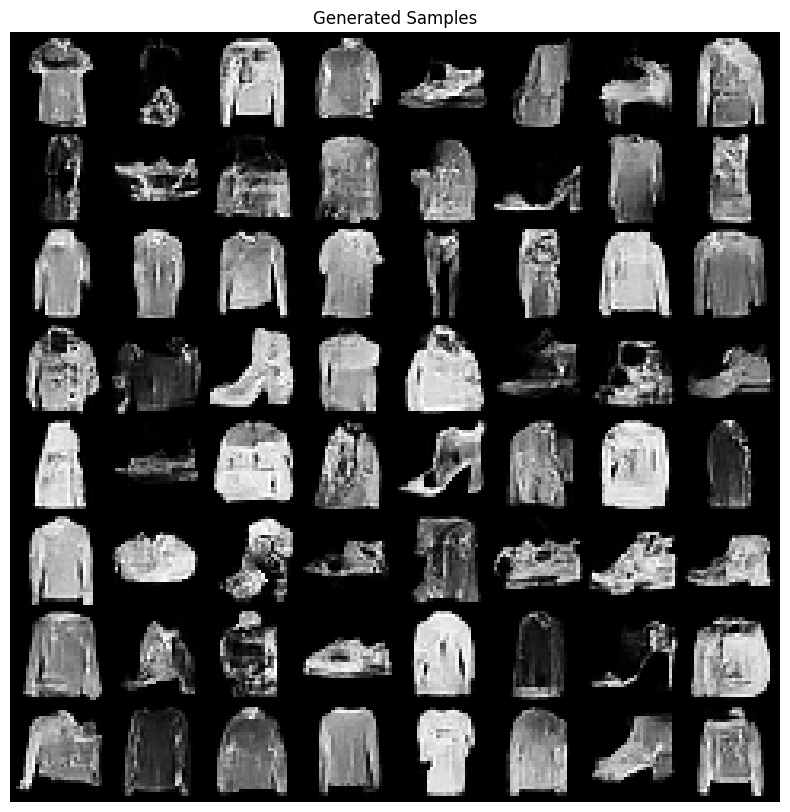

In [ ]:
model.eval()
with torch.no_grad():
    # z1: batch x 2 x 14 x 14 (factored out at scale 1)
    # z2: batch x 8 x 7 x 7   (final output at scale 2)

    z1 = torch.randn(64, 2, 14, 14).to(DEVICE)
    z2 = torch.randn(64, 8, 7, 7).to(DEVICE)

    # Pass as list [z1, z2]
    samples = model([z1, z2], reverse=True)
    show_samples(samples, "Generated Samples")

### Latent space interpolation
Interpolating between two random latent vectors

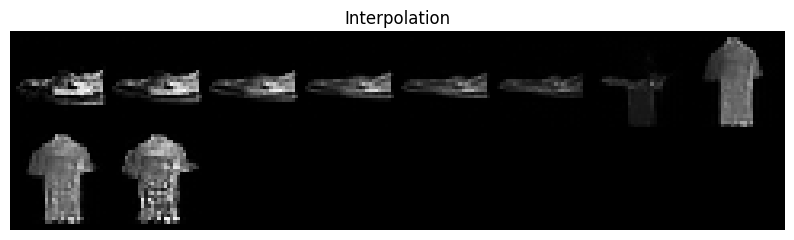

In [7]:
model.eval()
with torch.no_grad():
    z1_a = torch.randn(1, 2, 14, 14).to(DEVICE)
    z2_a = torch.randn(1, 8, 7, 7).to(DEVICE)

    z1_b = torch.randn(1, 2, 14, 14).to(DEVICE)
    z2_b = torch.randn(1, 8, 7, 7).to(DEVICE)

    steps = 10
    interpolated_samples = []

    for alpha in torch.linspace(0, 1, steps):
        z1_interp = z1_a * (1 - alpha) + z1_b * alpha
        z2_interp = z2_a * (1 - alpha) + z2_b * alpha

        sample = model([z1_interp, z2_interp], reverse=True)
        interpolated_samples.append(sample)

    interpolated_samples = torch.cat(interpolated_samples, dim=0)
    show_samples(interpolated_samples, "Interpolation")